In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize']=(25,25)
import bbox_finder

In [3]:
def overlap(a,b):
    mid_a=[(a[0]+a[2])/2,(a[1]+a[3])/2]
    mid_b=[(b[0]+b[2])/2,(b[1]+b[3])/2]
    if(np.abs(mid_a[0]-mid_b[0])*2<(a[2]+b[2]-a[0]-b[0]+200) and np.abs(mid_a[1]-mid_b[1])*2<(a[3]+b[3]-a[1]-b[1])+20):
        return True
    return False
        

In [4]:
def iou(a,b):
    union=[0,0,0,0]
    union[0]=min(a[0],b[0])
    union[2]=max(a[2],b[2])
    union[1]=min(a[1],b[1])
    union[3]=max(a[3],b[3])
    return union


In [5]:
def combine_box_rec(box,array):
    if(len(array)==0):
        return box,array
    array = np.delete(array, np.flatnonzero((array == box).all(1)), axis=0)
    a=0
    
    for x in array:
        if(overlap(box,x)):
            a=1
            box=iou(box,x)
            array= np.delete(array, np.flatnonzero((array == x).all(1)), axis=0)
            break
    if(a==0):
        return box,array
    x,arr=combine_box_rec(box,array)        
    return x,arr
            

In [6]:
def combine_box(arr):
    bbox=[]
    while True:
        val,arr=combine_box_rec(arr[0],arr)
        bbox.append(val)
        if(len(arr)==0):
            break
    return bbox    

In [7]:
def extract_contours(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,150,255,cv2.THRESH_BINARY_INV) 
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    dilated = cv2.dilate(thresh,kernel,iterations = 13)
    contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 
    contour_list=[]
    last_box=None
    for contour in contours:
        [x,y,w,h]=cv2.boundingRect(contour)
        contour_list.append([x,y,x+w,y+h])
    bbox=combine_box(np.array(contour_list))
    n=1
    for x in bbox:
        cv2.rectangle(img,(x[0],x[1]),(x[2],x[3]),(255,0,255),2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,str(n),(x[0],x[1]), font, 4,(0,255,255),2,cv2.LINE_AA)
        n=n+1
    return img,pd.DataFrame(bbox)

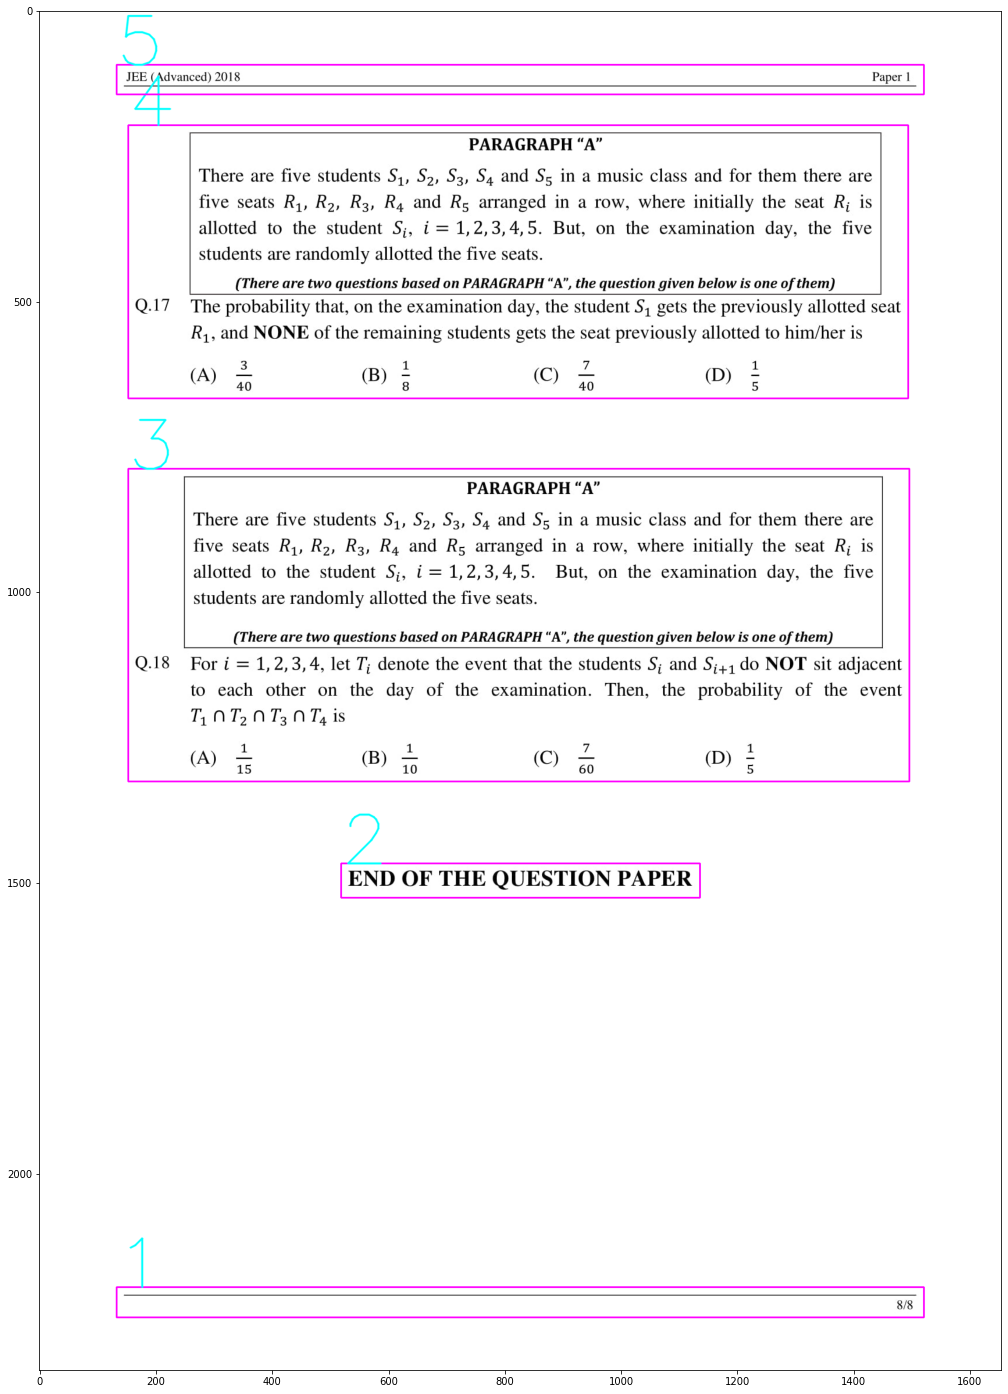

In [9]:
img=cv2.imread('./paper1/32.jpg')
countoured_img,bbox=bbox_finder.extract_contours(img)
plt.imshow(countoured_img)
bbox.columns=["xmin","ymin","xmax","ymax"]
bbox['img']="30.jpg"

In [156]:
#img=cv2.imread('./paper1/07.jpg')
#i=bbox.iloc[8]
#plt.imshow(cv2.rectangle(img,(i['xmin'],i['ymin']),(i['xmax'],i['ymax']),(255,0,255),2))

In [173]:
bbox['class']=['w','w','p','p','w']
bbox

,xmin,ymin,xmax,ymax,img,class
0,133,2195,1521,2247,32.jpg,w
1,519,1466,1136,1525,32.jpg,w
2,153,787,1496,1325,32.jpg,p
3,153,196,1494,666,32.jpg,p
4,133,92,1521,143,32.jpg,w


In [174]:
data=pd.read_csv('danvk_train.csv')
data=data.append(bbox)
data.to_csv('danvk_train.csv',index=False)

In [175]:
data

,class,img,xmax,xmin,ymax,ymin
0,w,01.jpg,1515,1454,2247,2205
1,w,01.jpg,1042,133,2223,2195
2,o,01.jpg,517,264,1939,1838
3,o,01.jpg,519,264,1767,1706
4,o,01.jpg,489,264,1675,1574
5,o,01.jpg,511,264,1543,1443
6,q,01.jpg,1478,168,1390,1156
7,i,01.jpg,1521,133,1086,92
8,w,02.jpg,1515,1451,2246,2205
9,w,02.jpg,1042,133,2223,2195
